# Adaptive Collocation Sampling

We will be using the Helmholtz Equation to show this.

In [1]:
import jax
import jax.numpy as jnp

import optax
from flax import linen as nn

import sys
import os

import time
import scipy

# Add /src to path
path_to_src = os.path.abspath(os.path.join(os.getcwd(), '../../../src'))
if path_to_src not in sys.path:
    sys.path.append(path_to_src)

from KAN import KAN
from PIKAN import *

import numpy as np

import matplotlib.pyplot as plt

## Collocation Points

In [2]:
# Generate Collocation points for PDE
N = 2**12
collocs = jnp.array(sobol_sample(np.array([-1,-1]), np.array([1,1]), N)) # (4096, 2)

# Generate Collocation points for BCs
N = 2**6

BC1_colloc = jnp.array(sobol_sample(np.array([-1,-1]), np.array([-1,1]), N)) # (64, 2)
BC1_data = jnp.zeros(BC1_colloc.shape[0]).reshape(-1,1) # (64, 1)

BC2_colloc = jnp.array(sobol_sample(np.array([-1,-1]), np.array([1,-1]), N)) # (64, 2)
BC2_data = jnp.zeros(BC2_colloc.shape[0]).reshape(-1,1) # (64, 1)

BC3_colloc = jnp.array(sobol_sample(np.array([1,-1]), np.array([1,1]), N)) # (64, 2)
BC3_data = jnp.zeros(BC3_colloc.shape[0]).reshape(-1,1) # (64, 1)

BC4_colloc = jnp.array(sobol_sample(np.array([-1,1]), np.array([1,1]), N)) # (64, 2)
BC4_data = jnp.zeros(BC4_colloc.shape[0]).reshape(-1,1) # (64, 1)

# Create lists for BCs
bc_collocs = [BC1_colloc, BC2_colloc, BC3_colloc, BC4_colloc]
bc_data = [BC1_data, BC2_data, BC3_data, BC4_data]

### Loss Function

In [3]:
def pde_loss(params, collocs, state):
    # Eq. parameters
    k = jnp.array(1.0, dtype=float)
    a1 = jnp.array(1.0, dtype=float)
    a2 = jnp.array(4.0, dtype=float)
    
    # Define the model function
    variables = {'params' : params, 'state' : state}
    
    def u(vec_x):
        y, spl = model.apply(variables, vec_x)
        return y
        
    # Physics Loss Terms
    u_xx = gradf(u, 0, 2)  # 2nd order derivative of x
    u_yy = gradf(u, 1, 2) # 2nd order derivative of y

    sines = jnp.sin(a1*jnp.pi*collocs[:,[0]])*jnp.sin(a2*jnp.pi*collocs[:,[1]])
    source = -((a1*jnp.pi)**2)*sines - ((a2*jnp.pi)**2)*sines + k*sines
    
    # Residual
    pde_res = u_xx(collocs) + u_yy(collocs) + (k**2)*u(collocs) - source
    
    return pde_res

## Training

In [4]:
# Initialize model
layer_dims = [2, 8, 8, 1]
model = KAN(layer_dims=layer_dims, k=3, const_spl=False, const_res=False, add_bias=True, grid_e=0.05)
variables = model.init(jax.random.PRNGKey(0), jnp.ones([1, 2]))

# Define learning rates for scheduler
lr_vals = dict()
lr_vals['init_lr'] = 0.001
lr_vals['scales'] = {0 : 1.0}

# Define epochs for grid adaptation
adapt_every = 275
adapt_stop = 5000
grid_adapt = [i * adapt_every for i in range(1, (adapt_stop // adapt_every) + 1)]

# Define epochs for grid extension, along with grid sizes
grid_extend = {0 : 3}

# Define global loss weights
glob_w = [jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float)]

# Initialize RBA weights
loc_w = [jnp.ones((collocs.shape[0],1)), jnp.ones((BC1_colloc.shape[0],1)),
         jnp.ones((BC2_colloc.shape[0],1)), jnp.ones((BC3_colloc.shape[0],1)),
         jnp.ones((BC3_colloc.shape[0],1))]

In [5]:
num_epochs = 1000

model, variables, train_losses = train_PIKAN(model, variables, pde_loss, collocs, bc_collocs, bc_data, glob_w=glob_w, 
                                             lr_vals=lr_vals, adapt_state=True, loc_w=loc_w, nesterov=True, 
                                             num_epochs=num_epochs, grid_extend=grid_extend, grid_adapt=grid_adapt, 
                                             colloc_adapt={'epochs' : []})

Epoch 0: Performing grid update
Total Time: 27.695093393325806 s
Average time per iteration: 0.0277 s


## Adaptive Collocation Sampling Example

In [6]:
# Sample M points from Sobol
M = 2**16
sample = jnp.array(sobol_sample(np.array([0,-1]), np.array([1,1]), M))
# Draw k, c hyperparameters
k, c = jnp.array(3.0, dtype=float), jnp.array(1.0, dtype=float)

In [7]:
# Calculate residuals of PDE
resids = jnp.abs(pde_loss(variables['params'], sample, variables['state']))
# Raise to power k
ek = jnp.power(resids, k)
# Divide by mean and add c
px = (ek/jnp.mean(ek)) + c
# Normalize
px_norm = (px / jnp.sum(px))[:,0]
# Draw ids for the sampled points using px_norm
# Note that they key can be added as a function argument, for now there's no reason to
X_ids = jax.random.choice(key=jax.random.PRNGKey(0), a=sample.shape[0], shape=(collocs.shape[0],), replace=False, p=px_norm)
# Replace collocation points
new_collocs = sample[X_ids]

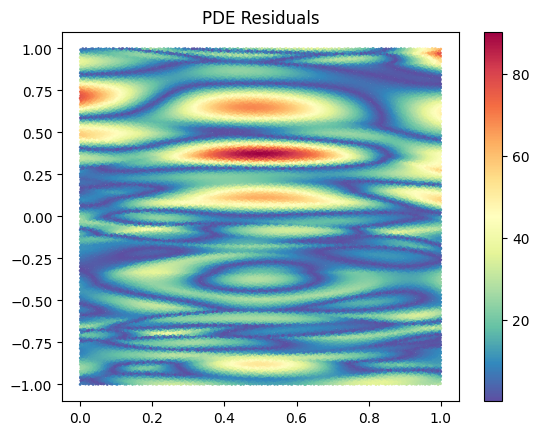

In [8]:
scatter = plt.scatter(sample[:,0], sample[:,1], c=resids, cmap='Spectral_r', s=1)
plt.colorbar(scatter)
plt.title('PDE Residuals')
plt.show()

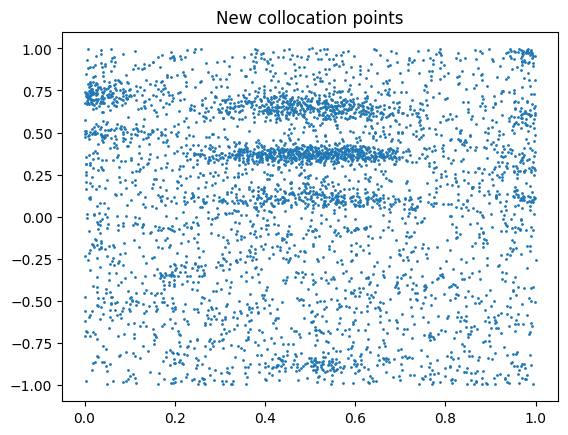

In [9]:
scatter = plt.scatter(new_collocs[:,0], new_collocs[:,1], s=1)
plt.title('New collocation points')
plt.show()

In [10]:
np.savez('../Plots/data/collocs.npz', sample=sample, resids=resids, collocs=new_collocs)